In [35]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [11]:
def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)
    
def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)
        
def show_tables():
    q = '''SELECT
                name,
                type
            FROM sqlite_master
            WHERE type IN ("table", "view")'''
    
    return run_query(q)

In [12]:
tables = show_tables()
tables

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


In [94]:
q = '''
WITH tot AS (SELECT SUM(quantity) q FROM invoice_line)

SELECT
    g.name gname,
    SUM(IFNULL(il.quantity, 0)) gquant,
    ROUND(CAST(SUM(IFNULL(il.quantity, 0)) AS Float)
        /CAST((SELECT tot.q FROM tot) AS Float), 2) qpercent
FROM track t
    LEFT JOIN invoice_line il ON il.track_id = t.track_id
    LEFT JOIN genre g ON t.genre_id = g.genre_id
GROUP BY
    gname
HAVING qpercent>0   
ORDER BY gquant
'''

top_genres = run_query(q)
top_genres.set_index('gname', drop=True, inplace=True)
top_genres

,gquant,qpercent
gname,,
Hip Hop/Rap,33,0.01
Reggae,35,0.01
Classical,47,0.01
Electronica/Dance,55,0.01
Pop,63,0.01
Easy Listening,74,0.02
Alternative,117,0.02
Jazz,121,0.03
Blues,124,0.03


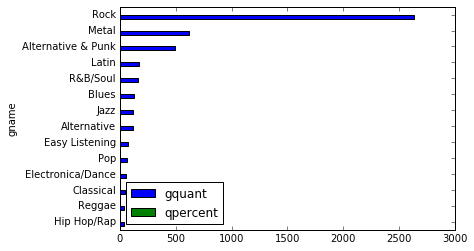

In [95]:
top_genres.plot(kind='barh')

plt.show()

In [103]:
q = '''
SELECT
e.first_name || ' ' || e.last_name ename,
SUM(i.total) total
FROM employee e
LEFT JOIN customer c ON e.employee_id = c.support_rep_id
LEFT JOIN invoice i ON c.customer_id = i.customer_id
WHERE i.total IS NOT NULL
GROUP BY ename
ORDER BY total DESC
'''

sales = run_query(q)
sales.set_index('ename', drop=True, inplace=True)
sales

,total
ename,
Jane Peacock,1731.51
Margaret Park,1584.00
Steve Johnson,1393.92


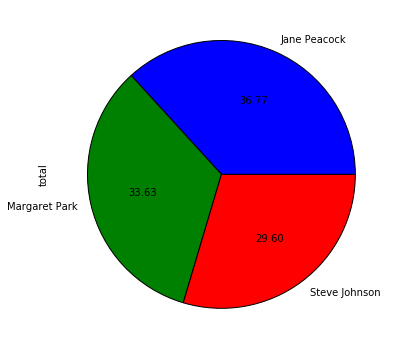

In [106]:
sales['total'].plot.pie(figsize=(6,6), autopct='%.2f')

For each country, include:
-total number of customers
-total value of sales
-average value of sales per customer
-average order value

In [126]:
q = '''
WITH cus AS (
    SELECT 
        c.customer_id,
        c.country,
        SUM(i.total) as total,
        COUNT(DISTINCT i.invoice_id) as count_order
    FROM customer c 
        LEFT JOIN invoice i ON c.customer_id = i.customer_id
    GROUP BY c.customer_id
),
countries AS (
    SELECT
        cus.country country,
        COUNT(DISTINCT cus.customer_id) as tot_customers,
        SUM(cus.total) as tot_sales,
        SUM(cus.count_order) as count_order
    FROM cus
    GROUP BY country    
)

SELECT 
    CASE 
        WHEN c.tot_customers = 1 THEN "Others"
        ELSE c.country
    END AS country_oth,
    SUM(c.tot_customers) AS tot_customers,
    SUM(c.tot_sales) AS tot_sales,
    SUM(c.tot_sales)/SUM(tot_customers) AS avg_customer,
    SUM(c.tot_sales)/SUM(count_order) AS avg_order
FROM countries c
GROUP BY country_oth
ORDER BY     
    CASE 
        WHEN c.tot_customers = 1 THEN 2
        ELSE 1
    END, 
    tot_sales DESC
'''

countries = run_query(q)
countries.set_index('country_oth', drop=True, inplace=True)
countries

,tot_customers,tot_sales,avg_customer,avg_order
country_oth,,,,
USA,13,1040.49,80.037692,7.942672
Canada,8,535.59,66.948750,7.047237
Brazil,5,427.68,85.536000,7.011148
France,5,389.07,77.814000,7.781400
Germany,4,334.62,83.655000,8.161463
Czech Republic,2,273.24,136.620000,9.108000
United Kingdom,3,245.52,81.840000,8.768571
Portugal,2,185.13,92.565000,6.383793
India,2,183.15,91.575000,8.721429


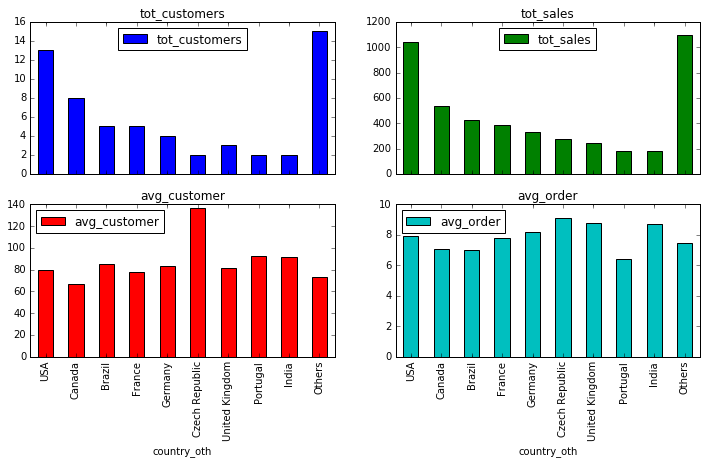

In [132]:
fig, axes = countries.plot(subplots=True, figsize=(12, 6), kind='bar', layout=(2, 2));

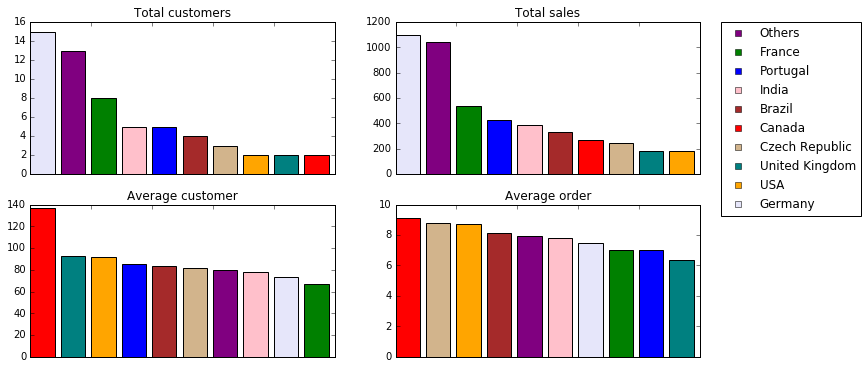

In [209]:
fig = plt.figure(figsize=(12, 6))
colors = ['purple', 'green', 'blue', 'pink', 'brown', 'red', 'tan', 'teal', 'orange', 'lavender']
colors_dict = dict(zip(countries.index.values, colors))

def generate_plot(pos, colname, title):
    ax = fig.add_subplot(2, 2, pos)
    series = countries[colname].sort_values(ascending=False)
    series_colors = [colors_dict[x] for x in series.index.values.tolist()]
    plt.bar(np.arange(len(series)), series, color=series_colors)
    ax.set_title(title);
    ax.set_xticklabels([])

generate_plot(1, 'tot_customers', 'Total customers')
generate_plot(2, 'tot_sales', 'Total sales')
generate_plot(3, 'avg_customer', 'Average customer')
generate_plot(4, 'avg_order', 'Average order')

# https://stackoverflow.com/questions/31303912/matplotlib-pyplot-scatterplot-legend-from-color-dictionary
markers = [plt.Line2D([0,0],[0,0],color=color, marker='s', linestyle='') for color in colors]
plt.legend(markers, colors_dict.keys(), numpoints=1, loc=2, bbox_to_anchor=(1.05, 2.24))

plt.show()

In [258]:
q = '''
WITH invs AS(
    SELECT
        il.invoice_id,
        a.album_id,
        COUNT(DISTINCT il.track_id) as tracks
    FROM invoice_line il
        LEFT JOIN track t ON il.track_id = t.track_id
        LEFT JOIN album a ON t.album_id = a.album_id
    GROUP BY il.invoice_id, a.album_id    
), albms AS(
    SELECT
        a.album_id,
        COUNT(DISTINCT t.track_id) as tracks
    FROM album a
        LEFT JOIN track t ON t.album_id = a.album_id       
    GROUP BY a.album_id 
), fulls AS(
SELECT
    i.invoice_id,
    MAX(CASE WHEN i.tracks = a.tracks THEN 1 ELSE 0 END) AS full_album
FROM invs i
    LEFT JOIN albms a ON a.album_id = i.album_id 
GROUP BY i.invoice_id
)

SELECT
    COUNT(DISTINCT invoice_id) invoices,
    SUM(full_album) full_albums
FROM fulls f
'''


invoices = run_query(q)
print('total invoices count: %d, full album purchases: %d' % (invoices.iloc[0, 0], invoices.iloc[0, 1]))

total invoices count: 614, full album purchases: 201
